### Check behavior

In [1]:
import sys
import os
sys.path.append('/root/capsule/aind-beh-ephys-analysis/code/beh_ephys_analysis')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from beh_functions import bonsai_to_nwb, plot_session_in_time_all
%matplotlib inline
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from beh_functions import parseSessionID, session_dirs, plot_session_glm, makedirs
from aind_dynamic_foraging_basic_analysis.plot.plot_foraging_session import plot_foraging_session, plot_foraging_session_nwb
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import plot_lick_analysis, cal_metrics, plot_met, load_data
from harp.clock import decode_harp_clock
from open_ephys.analysis import Session
import datetime
from aind_ephys_rig_qc.temporal_alignment import search_harp_line
from matplotlib.gridspec import GridSpec
import json

In [3]:
session = 'behavior_751004_2024-12-20_13-26-11'
session_dir = session_dirs(session)
qm_dict = {'soundcard_sync': None, 'ephys_sync': None}
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_file = os.path.join(session_dir['processed_dir'], f"{session}_process_record.txt")

# Redirect stdout to the file
if not os.path.exists(output_file):
    log_file = open(output_file, "w") 
else: 
    log_file = open(output_file, "a")
sys.stdout = log_file
print(f"Session: {session} processed at {timestamp}")


FileNotFoundError: [Errno 2] No such file or directory: '/root/capsule/scratch/751004/behavior_751004_2024-12-20_13-26-11/behavior_751004_2024-12-20_13-26-11_process_record.txt'

In [3]:
print(session)
session_dir = session_dirs(session)
aniID, datetime, string = parseSessionID(session)
session_json_dir = os.path.join(session_dir['raw_dir'], 'behavior')
session_json_files = []
for dir, _, files in os.walk(session_json_dir):
    for file in files:
        if file.endswith('.json') and aniID in file and 'model' not in file:
            session_json_files.extend([os.path.join(dir, file)])
print(f'{len(session_json_files)} session json files found.')
if len(session_json_files) == 1:
    session_json_file = session_json_files[0]
    if os.path.exists(os.path.join(session_dir['beh_fig_dir'], session + '.nwb')):
        print('NWB file already exists.')
    else:
        print('Processing NWB:')
        success, nwb_file = bonsai_to_nwb(session_json_file, os.path.join(session_dir['beh_fig_dir'], session + '.nwb'))

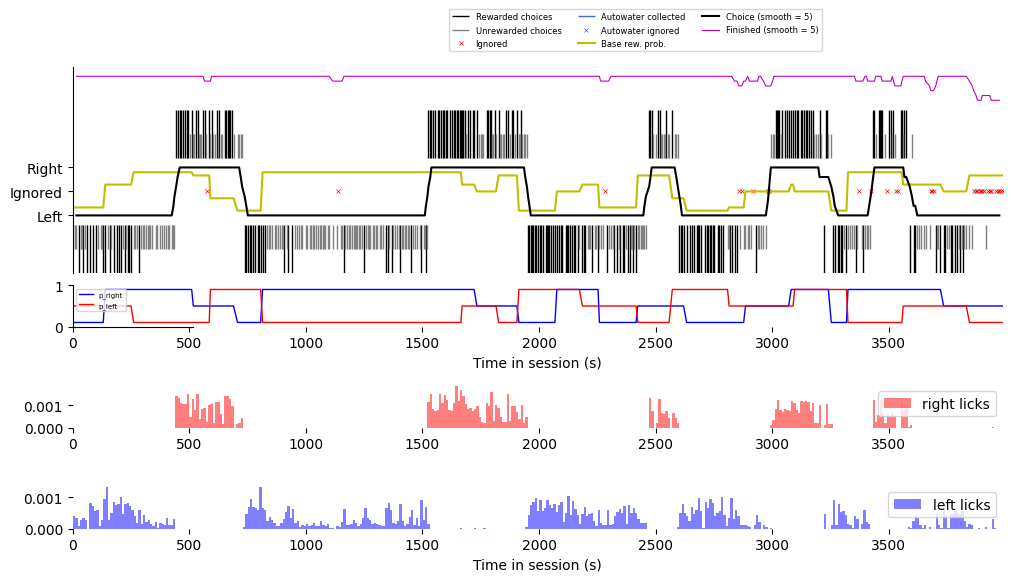

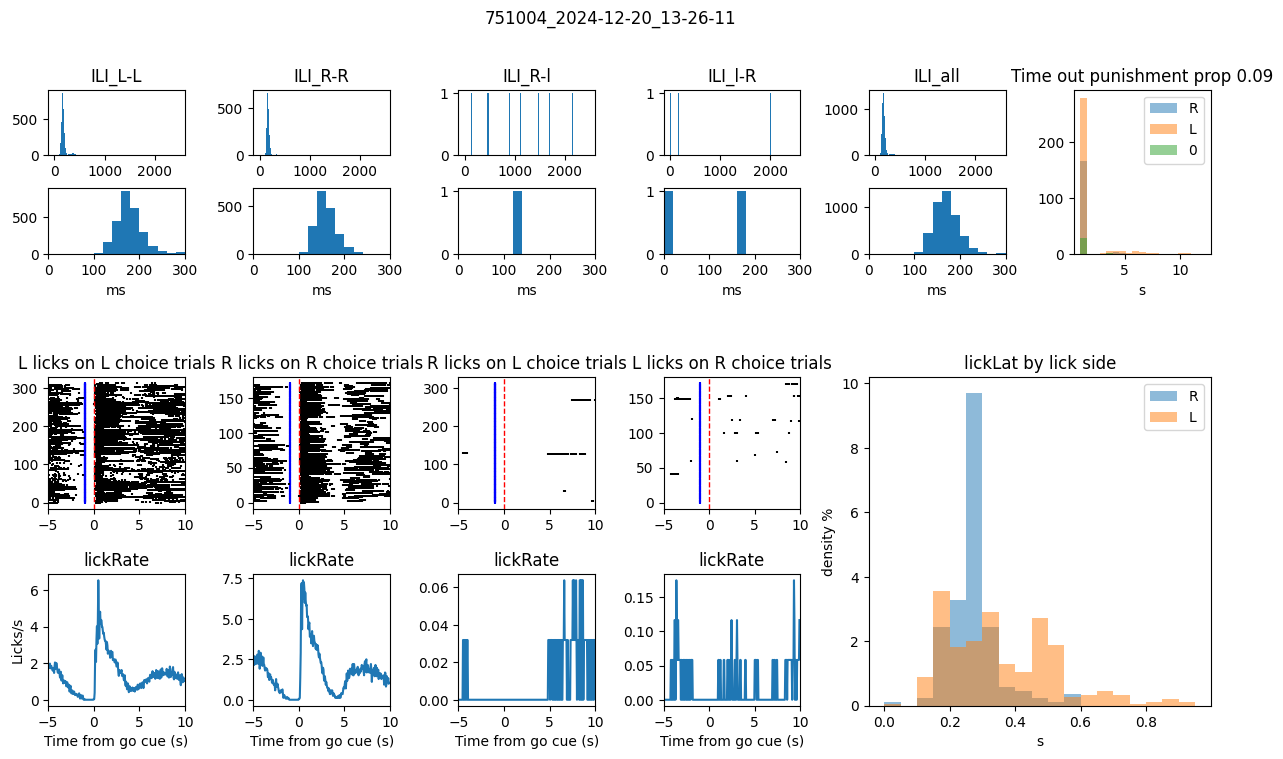

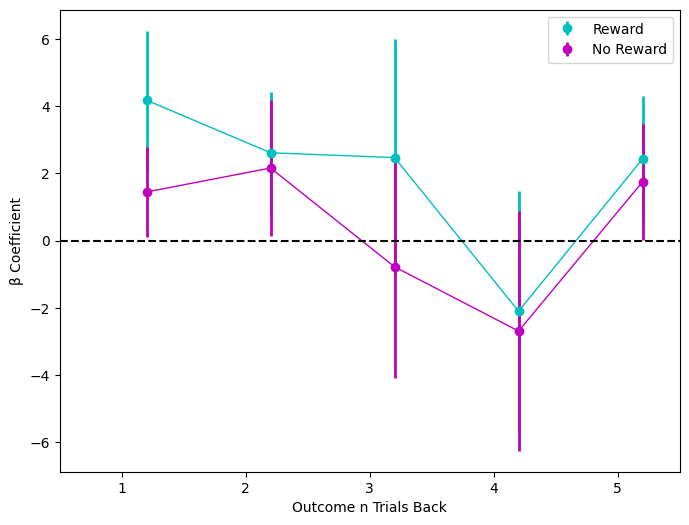

In [5]:
nwb_file = os.path.join(session_dir['beh_fig_dir'], session + '.nwb')
if not os.path.exists(nwb_file):
    print('NWB file does not exist.')
else:
    print('Plotting session.')
    nwb = load_nwb_from_filename(nwb_file)
    fig = plot_session_in_time_all(nwb)
    fig.savefig(os.path.join(session_dir['beh_fig_dir'], session + '_choice_reward.png'))
    display(fig)
    
    fig, _ = plot_lick_analysis(nwb)
    fig.savefig(os.path.join(session_dir['beh_fig_dir'], session + '_lick_analysis.png'))
    display(fig)

    fig, _ = plot_session_glm(nwb, tMax=5)
    fig.savefig(os.path.join(session_dir['beh_fig_dir'], session + '_glm.png'))
    display(fig)

    plt.close('all')

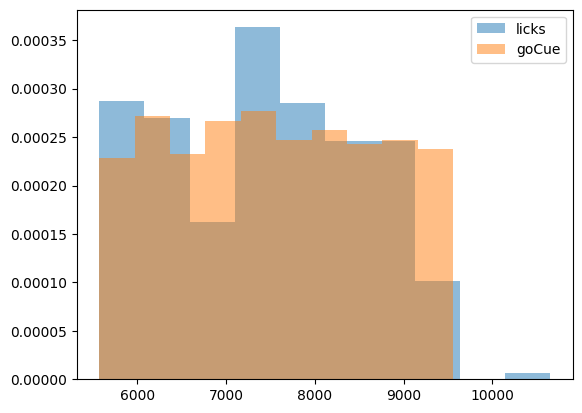

In [9]:
left_licks = nwb.acquisition["left_lick_time"].timestamps[:]
right_licks = nwb.acquisition["right_lick_time"].timestamps[:]
all_licks = np.sort(np.concatenate((right_licks, left_licks)))
df_trial = nwb.trials.to_dataframe()
plt.figure()
plt.hist(all_licks, alpha=0.5, label='licks', density=True)
plt.hist(df_trial['goCue_start_time'], alpha=0.5, label='goCue', density=True)
plt.legend()
plt.savefig(os.path.join(session_dir['beh_fig_dir'], session + '_licks_vs_goCue.pdf'))
if np.abs(np.mean(all_licks) - np.mean(df_trial['goCue_start_time'])) > 5*60:
    print(f'{session} sound card is not synced.')
    qm_dict['soundcard_sync'] = False
else:
    print(f'{session} sound card is synced.')
    qm_dict['soundcard_sync'] = True

In [13]:
sys.stdout = sys.__stdout__
# Close the file
log_file.close()
qm_file = os.path.join(session_dir['processed_dir'], f"{session}_qm.json")
with open(qm_file, 'w') as f:
    json.dump(qm_dict, f)

### For ephys check and alignment

In [3]:
session = Session(session_dir['raw_dir'])  
recording = session.recordnodes[0].recordings[0]
harp_line, nidaq_stream_name, source_node_id, figure = search_harp_line(recording, session_dir['session_dir'])
figure.savefig(os.path.join(session_dir['alignment_dir'], 'harp_line.png'))
print(F'Harp line {harp_line} found in {session')

OSError: [Errno 19] No such device

In [4]:
events = recording.events
harp_events = events[
    (events.stream_name == nidaq_stream_name)
    & (events.processor_id == source_node_id)
    & (events.line == harp_line[0])
]

harp_states = harp_events.state.values
harp_timestamps_local = harp_events.timestamp.values
local_times, harp_times = decode_harp_clock(
    harp_timestamps_local, harp_states
)
np.save(os.path.join(session_dir['alignment_dir'], 'harp_times.npy'), harp_times)
np.save(os.path.join(session_dir['alignment_dir'], 'local_times.npy'), local_times)

print('Harp times saved to: {}'.format(os.path.join(session_dir['alignment_dir'], 'harp_times.npy')))
print('Local times saved to: {}'.format(os.path.join(session_dir['alignment_dir'], 'local_times.npy')))

Harp times saved to: /root/capsule/scratch/behavior_717121_2024-06-15_10-00-58/alignment/harp_times.npy
Local times saved to: /root/capsule/scratch/behavior_717121_2024-06-15_10-00-58/alignment/local_times.npy


In [4]:
from open_ephys.analysis import Session

session = Session('/root/capsule/data/behavior_717121_2024-06-15_10-00-58_raw_data/ecephys/ecephys_clipped')
recording = session.recordnodes[0].recordings[0]
stream = recording.continuous

OSError: [Errno 19] No such device

In [4]:
session = Session('/root/capsule/data/behavior_717121_2024-06-15_10-00-58_raw_data/ecephys/ecephys_clipped')
recording = session.recordnodes[0].recordings[0]
stream = recording.continuous

OSError: [Errno 19] No such device

In [ ]:

# Reset stdout to default (so it prints normally again)
sys.stdout = sys.__stdout__
print(f"Output saved to {output_file}")
qm_file = os.path.join(session_dir['processed_dir'], f"{session}_qm.json")
with open(qm_file_file, "w") as f:
    json.dump(qm_dict, f, indent=4)  # indent=4 for pretty formatting
